In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("health_study_dataset.csv")
df.columns = (df.columns.str.strip().str.replace(" ", "_").str.lower())

In [2]:
mean_age = df["age"].mean()
median_age = df["age"].median()
min_age = df["age"].min()
max_age = df["age"].max()

mean_weight = df["weight"].mean()
median_weight = df["weight"].median()
min_weight = df["weight"].min()
max_weight = df["weight"].max()

mean_height = df["height"].mean()
median_height = df["height"].median()
min_height = df["height"].min()
max_height = df["height"].max()

mean_systolic_bp = df["systolic_bp"].mean()
median_systolic_bp = df["systolic_bp"].median()
min_systolic_bp = df["systolic_bp"].min()
max_systolic_bp = df["systolic_bp"].max()

mean_cholesterol = df["cholesterol"].mean()
median_cholesterol = df["cholesterol"].median()
min_cholesterol = df["cholesterol"].min()
max_cholesterol = df["cholesterol"].max()

print(f"Medelvärde för åldern: {mean_age:.2f} år \nMedian för åldern: {median_age:.2f} år \nLägsta åldern: {min_age} år \nHögsta åldern: {max_age} år")
print()
print(f"Medelvärde för vikten: {mean_weight:.2f} kg \nMedian för vikten: {median_weight:.2f} kg \nLägsta vikten: {min_weight} kg \nHögsta vikten: {max_weight} kg")
print()
print(f"Medelvärde för längden: {mean_height:.2f} cm \nMedian för längden: {median_height:.2f} cm \nKortast: {min_height} cm \nLängst: {max_height} cm")
print()
print(f"Medelvärde för systoliskt bloodtryck: {mean_systolic_bp:.2f} \nMedian för systoliskt bloodtryck: {median_systolic_bp:.2f} \nLägsta systoliska bloodtryck: {min_systolic_bp} \nHögsta systoliska bloodtryck: {max_systolic_bp} cm")
print()
print(f"Medelvärde för kolesterol: {mean_cholesterol:.2f} \nMedian för kolesterol: {median_cholesterol:.2f} \nLägst kolesterol: {min_cholesterol} \nHögst kolesterol: {max_height}")

Medelvärde för åldern: 49.43 år 
Median för åldern: 50.00 år 
Lägsta åldern: 18 år 
Högsta åldern: 90 år

Medelvärde för vikten: 73.41 kg 
Median för vikten: 73.20 kg 
Lägsta vikten: 33.7 kg 
Högsta vikten: 114.4 kg

Medelvärde för längden: 171.85 cm 
Median för längden: 171.35 cm 
Kortast: 144.4 cm 
Längst: 200.4 cm

Medelvärde för systoliskt bloodtryck: 149.18 
Median för systoliskt bloodtryck: 149.40 
Lägsta systoliska bloodtryck: 106.8 
Högsta systoliska bloodtryck: 185.9 cm

Medelvärde för kolesterol: 4.93 
Median för kolesterol: 4.97 
Lägst kolesterol: 2.5 
Högst kolesterol: 200.4


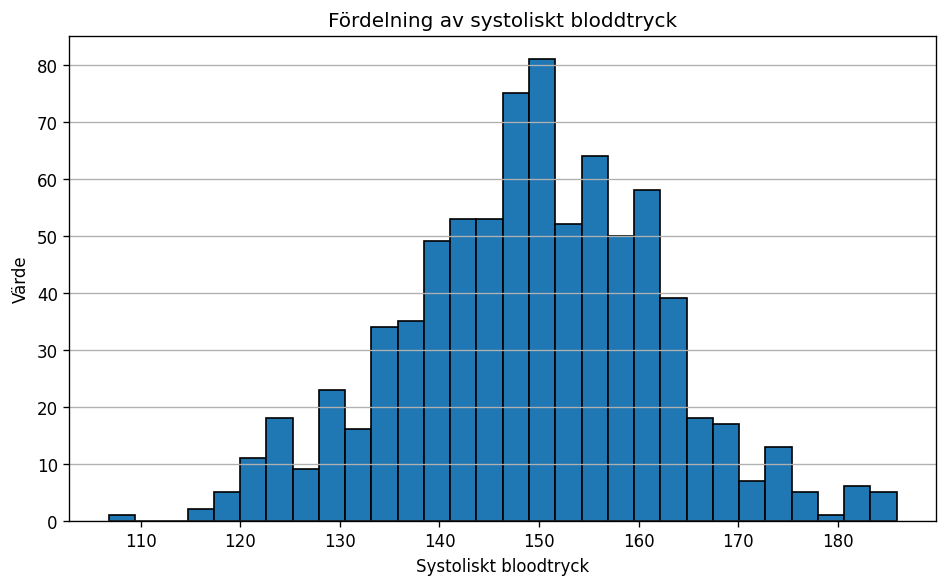

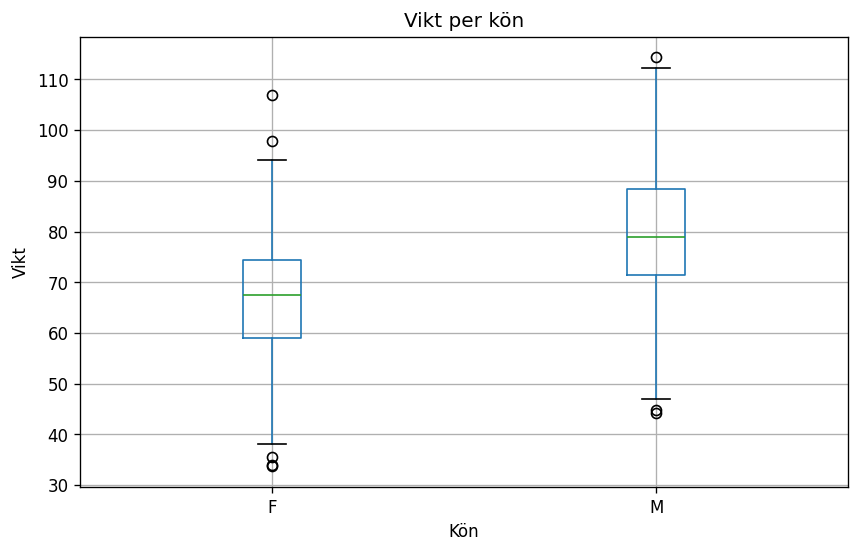

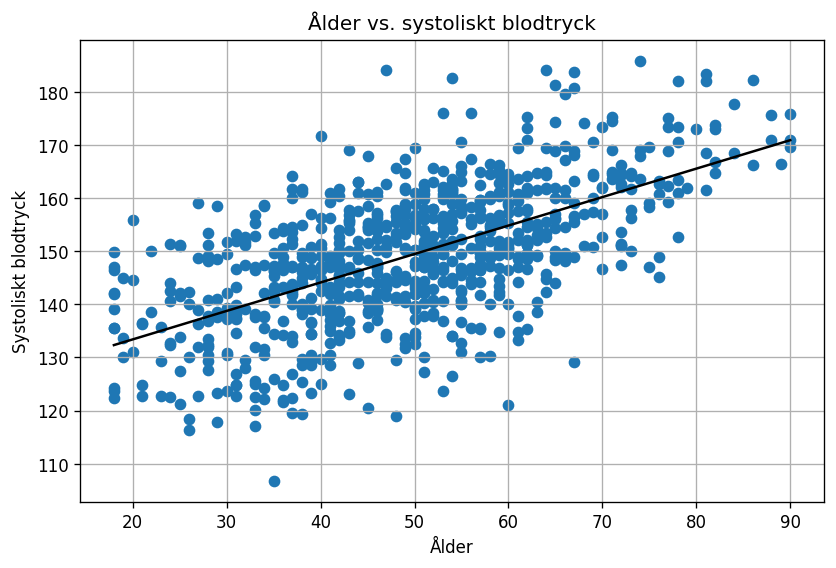

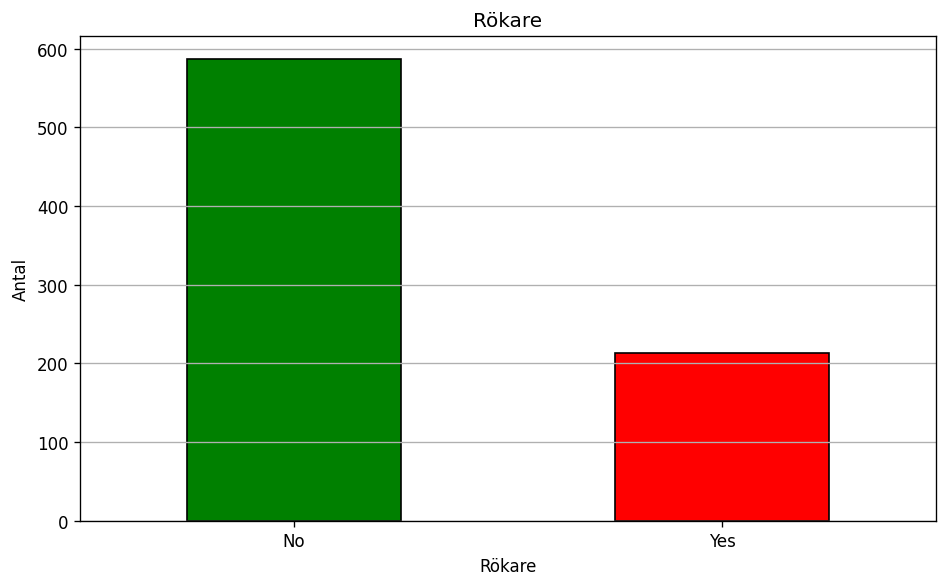

In [3]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120

fig, ax = plt.subplots()
ax.hist(df["systolic_bp"], bins=30, edgecolor='black')
ax.set_title("Fördelning av systoliskt bloddtryck")
ax.set_xlabel("Systoliskt bloodtryck")
ax.set_ylabel("Värde")
ax.grid(True, axis="y")
plt.tight_layout()

fig, ax = plt.subplots()
df.boxplot(column="weight", by="sex", ax=ax)
ax.set_title("Vikt per kön")
plt.suptitle("")
ax.set_xlabel("Kön")
ax.set_ylabel("Vikt")

x = df["age"].to_numpy()
y = df["systolic_bp"].to_numpy()

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_title("Ålder vs. systoliskt blodtryck")
ax.set_xlabel("Ålder")
ax.set_ylabel("Systoliskt blodtryck")
ax.grid(True)
k, m = np.polyfit(x, y, 1)
ix = np.argsort(x)
ax.plot(x[ix], (k*x + m)[ix], color="black")

fig, ax = plt.subplots()
smoker_counts = df["smoker"].value_counts()
smoker_counts.plot(kind="bar", color=["green", "red"], edgecolor="black", ax=ax)
ax.set_title("Rökare")
ax.set_xlabel("Rökare")
ax.set_ylabel("Antal")
ax.grid(True, axis="y")
plt.xticks(rotation=0)
plt.tight_layout()

Simulering kopplad till caset (använd numpy.random + seed)
- Beräkna andelen personer i datasetet som har sjukdomen.
- Använd numpy för att simulera 1000 slumpade personer med samma sannolikhet för sjukdom.
- Jämför den simulerade andelen med den verkliga andelen i datasetet.

In [5]:
disease_proportions = df["disease"].value_counts(normalize=True)
print("Andel som har sjukdom (0 = har inte sjukdom, 1 = har sjukdom):")
print(disease_proportions)

np.random.seed(42)
p_sick = 0.059
simulated = np.random.binomial(n=1, p=p_sick, size=1000)
print()
print("Andel som har sjukdom i stickprovet: 0.059")
print(f"Simulerad andel sjukdom: {simulated.mean():.3}")

Andel som har sjukdom (0 = har inte sjukdom, 1 = har sjukdom):
disease
0    0.94125
1    0.05875
Name: proportion, dtype: float64

Andel som har sjukdom i stickprovet: 0.059
Simulerad andel sjukdom: 0.056


## Medelvärde och konfidensintervall för systoliskt blodtryck
- Valde att göra normalapproximation med hjälp av t-fördelning då populationsstandardavvikelse är okänd.
- Konfidensintevallet blir litet då vi har ett stort stickprov med litet spridning (liten standardavvikelse)
- Uträkning med bootstrap gav ett snävare intervall vilket kan tyda på mer precis uträkning men kan också bero på att bootstrapen underskattar osäkerheten. Normalapproximation är mer konservativ.

In [12]:
def conf_intervall(x, confidence=0.95):
    mean = x.mean()
    std = x.std(ddof=1)
    n = len(x)
    t_stats = stats.t.ppf(1 - (1 - confidence) / 2, df=n - 1)
    margin = t_stats*(std/np.sqrt(n))
    return mean - margin, mean + margin

low, high = conf_intervall(df["systolic_bp"])
print(f"{mean_systolic_bp:.2f}")
print(f"95% CI = ({low:.2f}, {high:.2f})")


149.18
95% CI = (148.29, 150.07)


In [8]:
def ci_mean_bootstrap(x, B=5000, confidence=0.95):   
    x = np.asarray(x, dtype=float)
    n = len(x)
    boots = np.empty(B)
    for b in range(B):
        boot_sample = np.random.choice(x, size=n)
        boots[b] = np.mean(boot_sample)
    lower = np.percentile(boots, 100*confidence / 2)
    upper = np.percentile(boots, 100*(1 - confidence / 2))
    return lower, upper

low_boot, high_boot = ci_mean_bootstrap(df["systolic_bp"])
print(f"{mean_systolic_bp:.2f}")
print(f"95% CI = ({low_boot:.2f}, {high_boot:.2f})")

149.18
95% CI = (149.15, 149.21)


## Hypotesprövning
- HO: medelvärde för bloodtryck hos rökare = medelvärde för bloodtryck hos icke-rökare
- H1: medelvärde för bloodtryck hos rökare > medelvärde för bloodtryck hos icke-rökare

Vi gör ett ensidigt Welch's t-test

p-värdet > 0.05 vilket gör att vi inte kan förkasta nollhypotesen vid signifikansnivå 95%. Det finns inte tillräckligt statistikt stöd för att rökare har högre medelblodtryck än icke-rökare. 

In [18]:
mean_bp_smoker = df.groupby("smoker")["systolic_bp"].agg("mean")

bp_smoker = df[df["smoker"] == "Yes"]["systolic_bp"]
bp_no_smoker = df[df["smoker"] == "No"]["systolic_bp"]

t_stat, p_value = stats.ttest_ind(bp_smoker, bp_no_smoker, equal_var=False, alternative="greater")

print(mean_bp_smoker)
print(f"Teststatistika = {t_stat:.3f} \np-värde = {p_value:.3f}")


smoker
No     149.052981
Yes    149.524883
Name: systolic_bp, dtype: float64
Teststatistika = 0.450 
p-värde = 0.326
